# PROBLEM STATEMENT 
This notebook focuses on predicting the viral potential and engagement levels of news articles before they are published.
The objective is to use machine learning techniques to assist editorial teams in content strategy and resource allocation.


# Import Required Libraries
In this section, we import essential Python libraries:
- `pandas` and `numpy` for data handling.
- `matplotlib` and `seaborn` for data visualization.
- `TextBlob` for sentiment analysis.
- Several machine learning models from `sklearn` (Logistic Regression, Random Forest, SVM) to build and evaluate classifiers.


In [ ]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For advanced visualizations
from textblob import TextBlob  # For sentiment analysis
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.linear_model import LogisticRegression  # ML model
from sklearn.ensemble import RandomForestClassifier  # Ensemble model
from sklearn.svm import SVC  # Support Vector Machine model

# Data Collection
This section handles **data ingestion**. We read a CSV file `Articles.csv` containing metadata and text content of news articles. We also shuffle the dataset to prevent any chronological or order bias that may influence training and evaluation.

After shuffling, the dataset is split into two equal parts and saved separately. This might be useful for distributed processing or staged model development. We also confirm the splits by printing the row counts.

In [ ]:
# Load the dataset
# This is the step where external data is brought into the project.
data = pd.read_csv("Articles.csv", encoding="ISO-8859-1")

# Shuffle and split
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
half = len(data) // 2
part1 = data.iloc[:half]
part2 = data.iloc[half:]

# Save the two parts
part1.to_csv("dataset_part1.csv", index=False)
part2.to_csv("dataset_part2.csv", index=False)

# Print number of rows in original and each part
print("Original dataset size:", len(data))
print("Part 1 size:", len(part1))
print("Part 2 size:", len(part2))

# Optional: Check if all rows are accounted for
print("Total after split:", len(part1) + len(part2))

Original dataset size: 2692
Part 1 size: 1346
Part 2 size: 1346
Total after split: 2692


# Data Cleaning and Preprocessing
Here, we perform basic checks on the structure of the dataset. This step helps us:
- Identify column names
- Check for missing values
- Understand data types and distributions

We also clean the dataset to prepare it for modeling by:
- Converting the `Date` column into datetime format
- Checking for missing values
- Reviewing the number of records and columns

In [ ]:
# Clean the dataset to prepare it for analysis and modeling.
# Includes handling missing values and formatting the 'Date' column.
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Simple checks 
print("shape of the dataset:", data.shape)  # How many rows and columns do you have?
print("How many articles?", len(data))  # How big is your dataset?
print("What columns do I have?", data.columns.tolist())
print("Any missing data?", data.isnull().sum())  # Are there any gaps in your data?

print(data.head())
print(data.info())

shape of the dataset: (2692, 4)
How many articles? 2692
What columns do I have? ['Article', 'Date', 'Heading', 'NewsType']
Any missing data? Article     0
Date        0
Heading     0
NewsType    0
dtype: int64


# Exploratory Data Analysis (EDA)
 In this section, we create visualizations to gain insights into feature distributions, content types, publishing trends, and time-related behaviors. This is useful for understanding patterns that may influence virality.

We perform the following:
1. View article counts per `NewsType`.
2. Examine the distribution of article length.
3. Track how many articles are published per month.
4. Analyze publishing time trends throughout the day.

Top News Types:
NewsType
sports      1408
business    1284
Name: count, dtype: int64


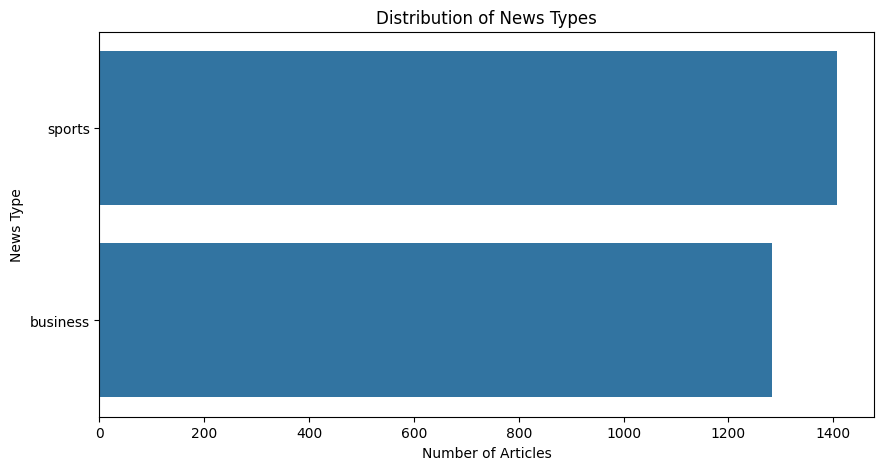

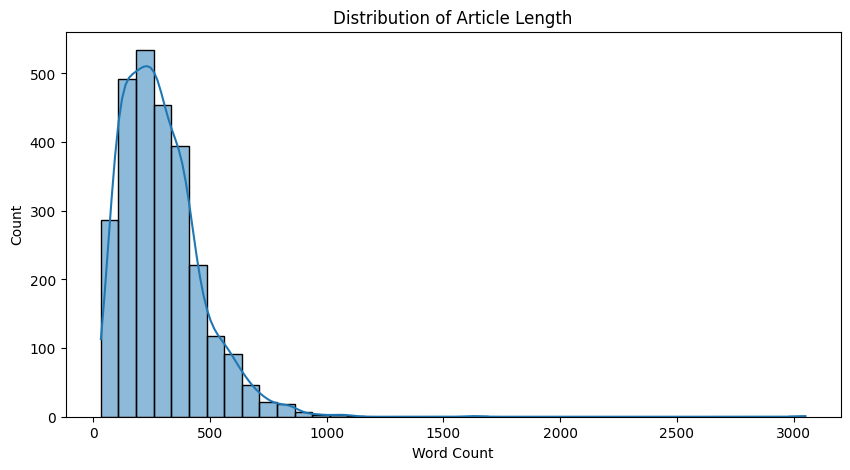

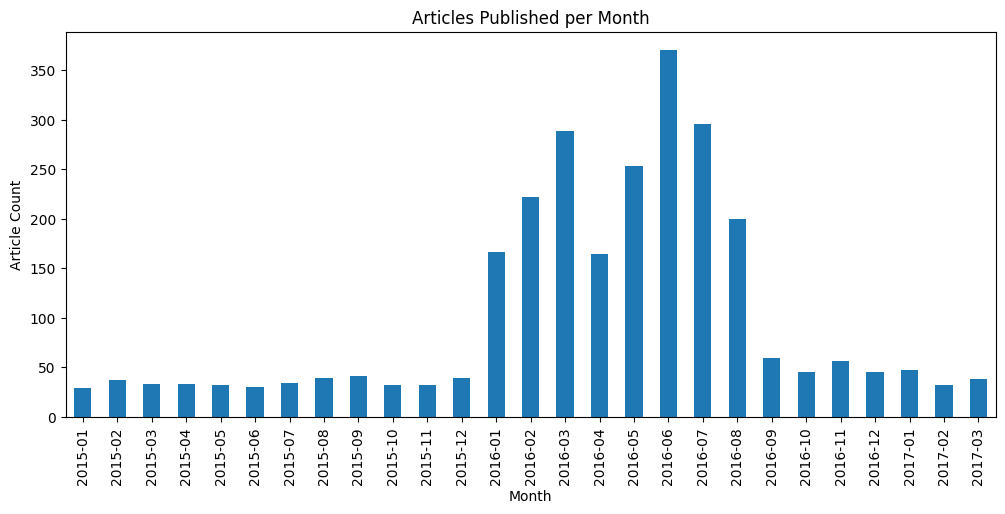

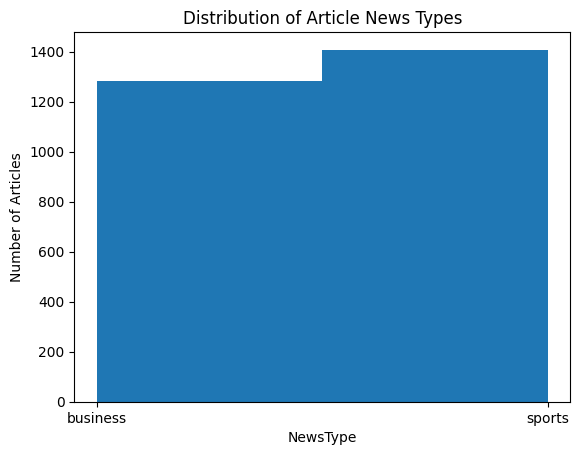

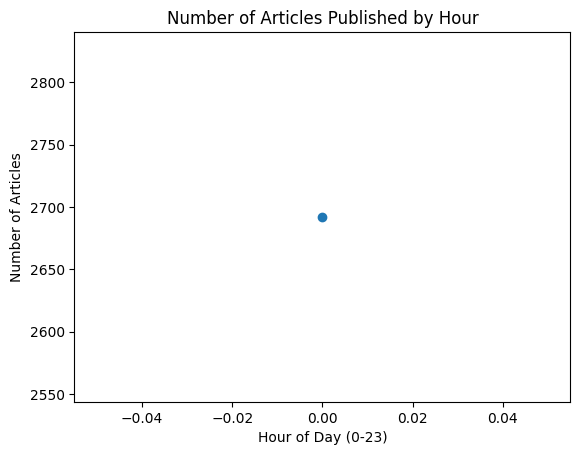

In [ ]:
# --- Univariate Analysis ---

# Print the most common types of news articles
print("Top News Types:")
print(data['NewsType'].value_counts())

# Plot News Type distribution
# This shows how many articles fall into each category of NewsType
plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='NewsType', order=data['NewsType'].value_counts().index)
plt.title("Distribution of News Types")
plt.xlabel("Number of Articles")
plt.ylabel("News Type")
plt.show()

# Article length analysis
# Calculate the number of words in each article
# Helps identify content density or length trends

data['ArticleLength'] = data['Article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(data['ArticleLength'], bins=40, kde=True)
plt.title("Distribution of Article Length")
plt.xlabel("Word Count")
plt.show()

# Time trend (articles per month)
# Converts the date to monthly periods for grouping and plotting
# Shows how many articles were published per month
data['Month'] = data['Date'].dt.to_period('M')
monthly_counts = data['Month'].value_counts().sort_index()
monthly_counts.plot(kind='bar', figsize=(12, 5), title="Articles Published per Month")
plt.ylabel("Article Count")
plt.show()

# Plot the distribution of NewsType using histogram (alternative view)
plt.hist(data['NewsType'], bins=len(data['NewsType'].unique()))
plt.title('Distribution of Article News Types')
plt.xlabel('NewsType')
plt.ylabel('Number of Articles')
plt.show()

# When are articles most frequently published?
# Extract hour of the day from timestamp
# Shows the frequency of article publications by hour (0-23)
data['hour'] = data['Date'].dt.hour
hourly_counts = data['hour'].value_counts().sort_index()

plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Number of Articles Published by Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Articles')
plt.show()

# Feature Engineering
This section includes both basic and engineered features to enhance the dataset. We add attributes like heading length, full text length, sentiment, day of week, and whether the article was published on a weekend.

This section transforms raw text into **quantifiable features** for machine learning. We compute:
- **Sentiment polarity** from headlines using TextBlob (ranges from -1 to 1)
- **Text length** of the article body (in word count)

These features aim to capture emotional tone and content depth, which can correlate with reader engagement.

(2692, 8)
Index(['Article', 'Date', 'Heading', 'NewsType', 'HeadingLength', 'Sentiment',
       'DayOfWeek', 'IsWeekend'],
      dtype='object')
NewsType
sports      1408
business    1284
Name: count, dtype: int64
count     2692.000000
mean      1859.129643
std       1080.577162
min        259.000000
25%       1083.000000
50%       1694.000000
75%       2379.000000
max      19242.000000
Name: text_length, dtype: float64
shape of the dataset: (2692, 10)


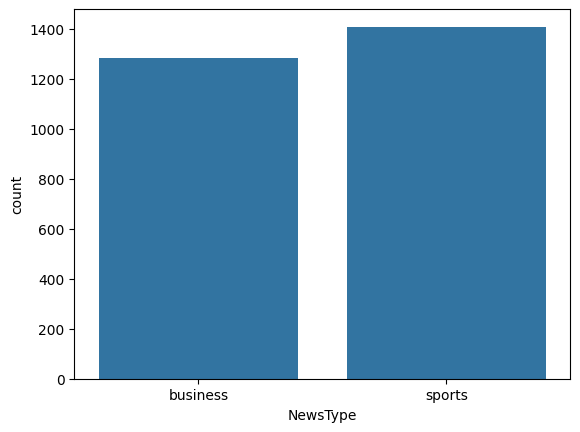

In [ ]:
# Ensure 'Date' is datetime format for time-based features
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Feature: Headline Length - Measures the number of characters in the heading
data['HeadingLength'] = data['Heading'].apply(lambda x: len(str(x)))

# Feature: Article Sentiment Polarity - Measures sentiment using TextBlob (-1 to 1)
data['Sentiment'] = data['Article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Feature: Day of Week - Extracts weekday name from the 'Date'
data['DayOfWeek'] = data['Date'].dt.day_name()

# Feature: Is Weekend - 1 if published on Saturday or Sunday, else 0
data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

# Preview newly created features
print(data[['HeadingLength', 'Sentiment', 'DayOfWeek', 'IsWeekend']].head())

# Dataset overview
print(data.shape)  # Number of rows and columns
print(data.columns)  # List all columns
print(data['NewsType'].value_counts())  # Count article categories

# Create a combined text field and calculate full text length
data['text'] = data['Heading'].astype(str) + ". " + data['Article'].astype(str)
data['text_length'] = data['text'].apply(len)
print(data['text_length'].describe())  # Summary stats for text length

# Model Selection & Training
We choose and train 4 models:
- Logistic Regression
- Ridge Classifier
- SVM with linear kernel
- Random Forest

Training uses train_test_split to prevent overfitting.

# This using pycaret 
In this section, we use **PyCaret**, an AutoML library, to automatically process the data and compare multiple models. This simplifies the ML pipeline and enables fast experimentation.


In [ ]:
from pycaret.classification import *

# Reload data to ensure fresh setup
data = pd.read_csv("Articles.csv", encoding="latin1")

# Optional: Combine heading + article to enrich context (better NLP signal)
data['text'] = data['Heading'].astype(str) + ". " + data['Article'].astype(str)

# Set up PyCaret for classification task
clf_setup = setup(
    data=data,
    target='NewsType',  # Our classification label
    session_id=42,  # For reproducibility
    text_features=['text'],   # 👈 Treat combined text column as NLP feature
    ignore_features=['Article', 'Heading', 'Date'],  # Drop raw unused columns
)

# Automatically compare and select the best-performing model
best_model = compare_models(exclude=['lda'])

# Predict using the best model on the same dataset (or new unseen data)
preds = predict_model(best_model)

# Save model to disk for future use
save_model(best_model, 'best_news_classifier')

,Description,Value
0,Session id,42
1,Target,NewsType
2,Target type,Binary
3,Target mapping,"business: 0, sports: 1"
4,Original data shape,"(2692, 5)"
5,Transformed data shape,"(2692, 24299)"
6,Transformed train set shape,"(1884, 24299)"
7,Transformed test set shape,"(808, 24299)"
8,Ignore features,3
9,Text features,1


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:14:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Quadratic Discriminant Analysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9979,0.9997,0.9979,0.9979,0.9979,0.9957,0.9958,5.7650
ridge,Ridge Classifier,0.9963,0.9999,0.9963,0.9963,0.9963,0.9926,0.9926,3.1710
svm,SVM - Linear Kernel,0.9958,0.9999,0.9958,0.9958,0.9958,0.9915,0.9915,2.0280
rf,Random Forest Classifier,0.9931,0.9994,0.9931,0.9931,0.9931,0.9862,0.9862,2.6350
knn,K Neighbors Classifier,0.9888,0.9987,0.9888,0.9890,0.9888,0.9776,0.9778,2.4120
nb,Naive Bayes,0.9841,0.9841,0.9841,0.9842,0.9841,0.9681,0.9682,2.2340
dt,Decision Tree Classifier,0.9443,0.9446,0.9443,0.9449,0.9443,0.8884,0.8890,1.8620


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Manual pipeline
This section manually builds NLP pipelines using TF-IDF and compares multiple models (Logistic Regression, SVM, Ridge, Random Forest). It involves:
- Cleaning and combining text
- Vectorizing with TF-IDF (n-grams)
- Training with hyperparameter tuning using GridSearchCV
- Evaluating each model on a held-out test set

In [ ]:
# 📚 Importing required libraries
import pandas as pd                            # For handling datasets
import re                                      # For text cleaning with regular expressions
from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text into numerical features
from sklearn.model_selection import train_test_split, GridSearchCV  # For data splitting and model tuning
from sklearn.linear_model import LogisticRegression, RidgeClassifier  # Classification models
from sklearn.ensemble import RandomForestClassifier                    # Tree-based model
from sklearn.svm import SVC                                            # Support Vector Machine
from sklearn.pipeline import Pipeline                                  # Combine steps into one ML pipeline
from sklearn.metrics import accuracy_score, precision_score, classification_report  # Evaluation metrics

# 🧼 Step 1: Preprocess text to make it clean and uniform
def clean_text(text):
    # Example input: "Breaking News!! 2023: Prices are UP!!!"
    # Output: "breaking news prices are up"
    text = text.lower()                          # Make all text lowercase
    text = re.sub(r'\d+', '', text)              # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)          # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra spaces
    return text

# 🧠 Step 2: Combine heading + article into one text column
# Reason: Headlines and body text both contain useful information
# Clean combined text for each part
part1 = part1.copy()  # Copy to avoid modifying original data
part2 = part2.copy()

part1['combined_text'] = (part1['Heading'] + ' ' + part1['Article']).apply(clean_text)  # Cleaned training text
part2['combined_text'] = (part2['Heading'] + ' ' + part2['Article']).apply(clean_text)  # Cleaned test text

# Split features and labels
X_val = part1['combined_text']                # Features for training
y_val = part1['NewsType']                     # Labels for training

X_test_final = part2['combined_text']         # Features for final test
y_test_final = part2['NewsType']              # Labels for final test

# Step 4: Define vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,         # Keep top 5000 most common words/phrases
    ngram_range=(1, 4),        # Use 1-word to 4-word phrases (e.g., "sports", "sports news today")
    min_df=2,                  # Ignore rare words that appear in only 1 document
    max_df=0.95                # Ignore very common words in more than 95% of docs
)

# 🔧 Step 5: Define multiple pipelines for model comparison
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),  # Linear baseline model
    "RidgeClassifier": RidgeClassifier(),                                         # Fast linear model with regularization
    "SVM": SVC(kernel='linear', probability=True),                               # Support Vector Machine
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)    # Ensemble decision tree model
}

# Dictionary to store best results
best_models = {}

# Loop over each model
for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    pipeline = Pipeline([
        ('tfidf', vectorizer),  # First step: convert text to numbers
        ('clf', model)          # Second step: apply classifier
    ])

    # Define parameter grid depending on the model
    if name == "LogisticRegression":
        param_grid = {
            'clf__C': [0.01, 0.1, 1, 10],                  # Regularization strength
            'clf__penalty': ['l2'],                        # Use L2 regularization
            'clf__solver': ['liblinear', 'saga']           # Solvers that support L2
        }
    elif name == "SVM":
        param_grid = {
            'clf__C': [0.1, 1, 10]                          # SVM margin hardness
        }
    elif name == "RandomForest":
        param_grid = {
            'clf__n_estimators': [100, 200],               # Number of trees
            'clf__max_depth': [None, 10, 20]               # Tree depth control
        }
    else:
        param_grid = {}  # RidgeClassifier has fewer parameters

    # Use GridSearchCV to find the best parameters via cross-validation
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_val, y_val)  # Train ONLY on part1

    # Evaluate on unseen part2
    y_pred = grid.predict(X_test_final)
    acc = accuracy_score(y_test_final, y_pred)                     # Test accuracy
    prec = precision_score(y_test_final, y_pred, average='macro') # Macro-averaged precision

    # Display results
    print(f"✅ Best Parameters for {name}:", grid.best_params_)
    print(f"✅ CV Accuracy for {name}: {grid.best_score_:.4f}")
    print(f"🔍 Test Accuracy  : {acc:.4f}")
    print(f"🔍 Test Precision : {prec:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_test_final, y_pred))  # Full report by class

    # Store the best performing model for later use
    best_models[name] = grid.best_estimator_

# ✅ You can now pick the best model manually or by comparing test accuracy



🔧 Training: LogisticRegression
✅ Best Parameters for LogisticRegression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
✅ CV Accuracy for LogisticRegression: 0.9955
🔍 Test Accuracy  : 0.9963
🔍 Test Precision : 0.9962

📋 Classification Report:
              precision    recall  f1-score   support

    business       0.99      1.00      1.00       635
      sports       1.00      0.99      1.00       711

    accuracy                           1.00      1346
   macro avg       1.00      1.00      1.00      1346
weighted avg       1.00      1.00      1.00      1346


🔧 Training: RidgeClassifier
✅ Best Parameters for RidgeClassifier: {}
✅ CV Accuracy for RidgeClassifier: 0.9963
🔍 Test Accuracy  : 0.9963
🔍 Test Precision : 0.9962

📋 Classification Report:
              precision    recall  f1-score   support

    business       0.99      1.00      1.00       635
      sports       1.00      0.99      1.00       711

    accuracy                           1.00      1346
  

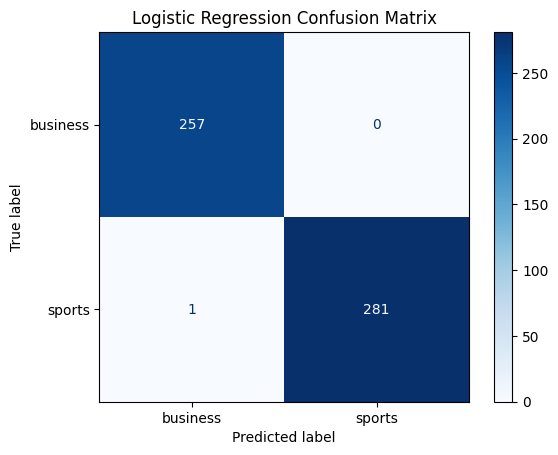

In [32]:


# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# MODEL EVALUATION

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score


models = {
    "Logistic Regression": lr,
    "Ridge Classifier": ridge,
    "SVM - Linear Kernel": svm,
    "Random Forest Classifier": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("Kappa:", cohen_kappa_score(y_test, y_pred))
    print("MCC:", matthews_corrcoef(y_test, y_pred))
    # AUC for multiclass (if model supports predict_proba)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro', multi_class='ovr')
        print("AUC:", auc)
    else:
        print("AUC: Not available for this model")


Logistic Regression
Accuracy: 0.9925788497217068
Recall: 0.9926764405985615
Precision: 0.9924999999999999
F1 Score: 0.9925745302253817
Kappa: 0.9851492650401577
MCC: 0.9851764247987088
AUC: 0.9998484305674209

Ridge Classifier
Accuracy: 0.9962894248608535
Recall: 0.9962865489018106
Precision: 0.9962865489018106
F1 Score: 0.9962865489018106
Kappa: 0.9925730978036211
MCC: 0.9925730978036211
AUC: Not available for this model

SVM - Linear Kernel
Accuracy: 0.9981447124304267
Recall: 0.9980916030534351
Precision: 0.9982014388489209
F1 Score: 0.9981430761545484
Kappa: 0.9962861651037325
MCC: 0.9962930358479615
AUC: Not available for this model

Random Forest Classifier
Accuracy: 0.9925788497217068
Recall: 0.9926764405985615
Precision: 0.9924999999999999
F1 Score: 0.9925745302253817
Kappa: 0.9851492650401577
MCC: 0.9851764247987088
AUC: 0.9996624135365283



Logistic Regression Confusion Matrix:


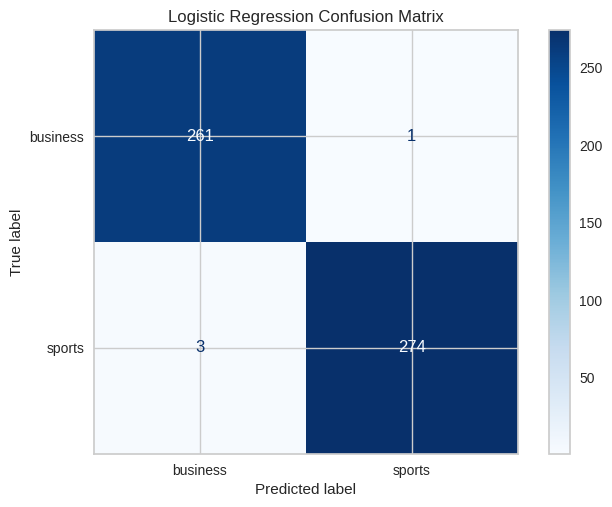


Ridge Classifier Confusion Matrix:


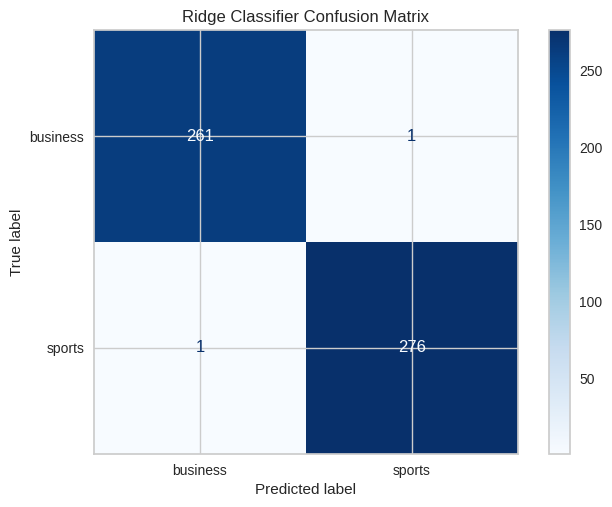


SVM - Linear Kernel Confusion Matrix:


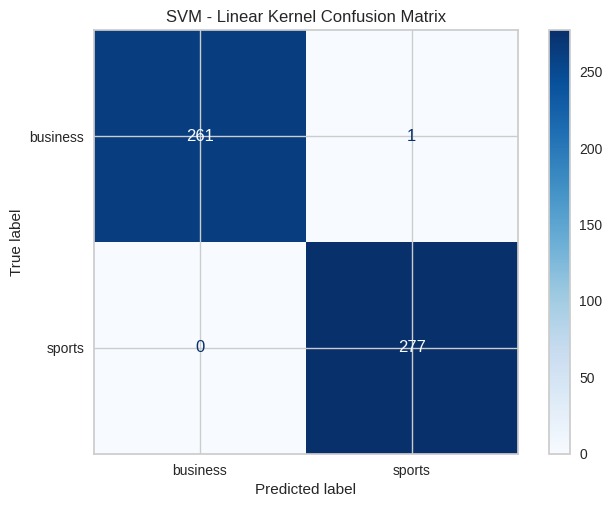


Random Forest Classifier Confusion Matrix:


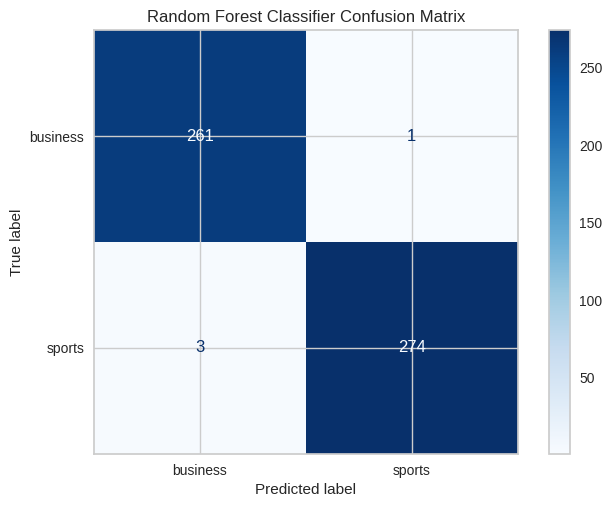

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()